In [13]:
import os

import numpy as np
import json
import pandas as pd
import re

from neuroglancer_utilities import neuroglancer_utilities

In [2]:
os.chdir('..')
import datajoint as dj
dj.conn()

Connecting thinh@ucsd-demo-db.datajoint.io:3306


DataJoint connection (connected) thinh@ucsd-demo-db.datajoint.io:3306

In [4]:
# Define common_atlas schema 
common_atlas_schema = dj.schema('common_atlas_v2')
common_atlas_schema.spawn_missing_classes()

In [25]:
with open('dj_local_conf_TNlocal.json') as f:
    dj_config_TNlocal = json.load(f)
TNlocal_conn = dj.Connection(host=dj_config_TNlocal['database.host'],
                            user=dj_config_TNlocal['database.user'],
                            password=dj_config_TNlocal['database.password'])

Connecting root@127.0.0.1:3306


In [27]:
# Define new schema for brain images
brain_images_schema = dj.schema(dj.config.get('database.prefix', '') + 'precomputed_brainstack',
                               connection=TNlocal_conn)

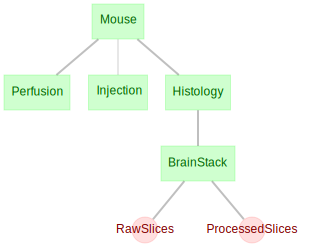

In [5]:
dj.ERD(common_atlas_schema)

In [33]:
BrainStack.heading

# 
mouse                : char(18)                     # Name for lab mouse, max 8 chars
---
stack_name           : varchar(10)                  # (Str) unique designation for each mouse
num_slices           : int                          # (int) total number of histology slices
num_valid_slices     : int                          # 
channels             : int                          # (int) number of channels for each slice
sorted_filenames     : varchar(50000)               # (Str) the sorted_filenames.txt file for each brain
human_annotated      : tinyint                      # (bool) does this stack have human annotations
planar_resolution_um : double                       # (double) 0.325 for AxioScanner, 0.46 from CSHL
section_thickness_um : double                       # (double) typically 20um

In [61]:
ProcessedSlices.heading

# 
mouse                : char(18)                     # Name for lab mouse, max 8 chars
---
aws_bucket           : varchar(40)                  # (Str) the name of the bucket the files are stored on
processed_stack      : varchar(50000)               # (Str) a sequence of each filepath of files stored on S3 seperated by '|'

In [38]:
brains = (BrainStack).fetch('stack_name', 'num_valid_slices')
brains

[array(['CHATM2', 'CHATM3', 'CSHL2', 'MD175', 'MD585', 'MD589', 'MD590',
        'MD591', 'MD592', 'MD593', 'MD594', 'MD595', 'MD598', 'MD599',
        'MD602', 'MD603', 'MD635', 'MD636', 'MD639', 'MD642', 'MD652',
        'MD653', 'MD657', 'MD658', 'MD661', 'MD662', 'UCSD001'],
       dtype=object),
 array([235, 293,  -1,  -1, 439, 443, 428, 455, 449, 444, 423, 437, 433,
        443, 438, 433, 437,  -1,  -1, 431, 479, 472, 441, 443, 438, 438,
        458], dtype=int64)]

In [60]:
brain_stack = (BrainStack & 'mouse = "MD585"').fetch1()
sorted_slices = brain_stack['sorted_filenames'].split('|')
sorted_slices[:10]

['Placeholder 1',
 'Placeholder 2',
 'MD585-N3-2015.07.16-19.48.34_MD585_1_0007 3',
 'MD585-IHC3-2015.07.16-15.26.44_MD585_1_0007 4',
 'MD585-N3-2015.07.16-19.48.34_MD585_2_0008 5',
 'MD585-IHC3-2015.07.16-15.26.44_MD585_2_0008 6',
 'MD585-N4-2015.07.16-19.50.10_MD585_1_0010 7',
 'Placeholder 8',
 'MD585-N4-2015.07.16-19.50.10_MD585_2_0011 9',
 'MD585-IHC4-2015.07.18-07.01.12_MD585_1_0010 10']

In [59]:
processed_stack = (ProcessedSlices & 'mouse = "MD585"').fetch1()
sorted_processedslices = processed_stack['processed_stack'].split('|')
sorted_processedslices[:10]

['CSHL_data_processed/MD585/MD585_prep2_lossless/MD585-IHC16-2015.08.19-13.14.51_MD585_3_0048_prep2_lossless.tif',
 'CSHL_data_processed/MD585/MD585_prep2_lossless/MD585-IHC17-2015.07.16-15.32.03_MD585_1_0049_prep2_lossless.tif',
 'CSHL_data_processed/MD585/MD585_prep2_lossless/MD585-IHC17-2015.07.16-15.32.03_MD585_2_0050_prep2_lossless.tif',
 'CSHL_data_processed/MD585/MD585_prep2_lossless/MD585-IHC17-2015.07.16-15.32.03_MD585_3_0051_prep2_lossless.tif',
 'CSHL_data_processed/MD585/MD585_prep2_lossless/MD585-IHC18-2015.07.16-15.35.58_MD585_1_0052_prep2_lossless.tif',
 'CSHL_data_processed/MD585/MD585_prep2_lossless/MD585-IHC18-2015.07.16-15.35.58_MD585_2_0053_prep2_lossless.tif',
 'CSHL_data_processed/MD585/MD585_prep2_lossless/MD585-IHC18-2015.07.16-15.35.58_MD585_3_0054_prep2_lossless.tif',
 'CSHL_data_processed/MD585/MD585_prep2_lossless/MD585-IHC19-2015.07.16-15.39.52_MD585_1_0055_prep2_lossless.tif',
 'CSHL_data_processed/MD585/MD585_prep2_lossless/MD585-IHC19-2015.07.16-15.39.52

In [ ]:
@brain_images_schema
class PrecomputedBrain(dj.Computed):
    definition = """
    -> ProcessedSlices
    ---
    aws_bucket: varchar(40)         
    precomputed_url: varchar(255)   
    """
    
    # hard-code keysource here, instead of all, only do one for MD585 for demonstration purpose
    key_source = (ProcessedSlices & 'mouse = "MD585"').fetch('KEY')
    
    make(self, key):
        s3_bucket_name_for_upload = 'mousebrainatlas-datajoint-jp2k'
        s3_creds_file = 's3-creds.json'
        
        mouse_info = (BrainStack & key).fetch1('stack_name', 'planar_resolution_um', 'section_thickness_um')
        mouse_info['sorted_filenames'] = mouse_info['sorted_filenames'].split('|')
        sorted_processedslices = (ProcessedSlices & key).fetch1('processed_stack')
        
        # -- download_ordered_files_from_s3
        f_infos = [(l.split(' ')[-1], re.search('[^\|]+' + re.escape(l.split(' ')[0]) + '[^\|]+', sorted_processedslices).group()) 
           if re.search('[^\|]+' + re.escape(l.split(' ')[0]) + '[^\|]+', sorted_processedslices) else (l.split(' ')[-1], 'Placeholder')
           for l in mouse_info['sorted_filenames']]
        
        folder_to_download_to = os.path.join('.', 's3_precomputed_temp', mouse_info['stack_name'])
        if not os.path.exists(folder_to_write_to):
            os.makedirs(folder_to_write_to)
            
        bucket = neuroglancer_utilities.get_bucket(s3_creds_file, (ProcessedSlices & key).fetch1('aws_bucket'))
        for idx, key in f_infos:
            if key != 'Placeholder': 
                fname_to_write, ext = os.path.splitext(os.path.split(key)[-1])
                fname_to_write = '_'.join([f'{int(idx):04d}', fname_to_write, ext])
                dest = os.path.join(folder_to_download_to, fname_to_write)
                bucket.download_file(key, dest)
                
        # -- convert to precomputed
        folder_to_convert_to = os.path.join('.', 's3_precomputed_temp', mouse_info['stack_name'] + '_precomputed')
        neuroglancer_utilities.convert_to_precomputed(folder_to_write_to, folder_to_convert_to, 
                                                     voxel_resolution=(mouse_info['planar_resolution_um'],
                                                                      mouse_info['planar_resolution_um'],
                                                                      mouse_info['section_thickness_um']) * 1000,
                                                     voxel_offset=(0, 0, 0))
        # -- upload to S3
        s3_dir_to_write_to = f'precomputed/{mouse_info["stack_name"]}'
        upload_directory_to_s3(s3_creds_file, s3_bucket_name_for_upload, folder_to_convert_to, s3_dir_to_write_to, overwrite=False)
        
        # insert
        precomputed_url = f'https://{s3_bucket_name_for_upload}.s3.amazonaws.com/{s3_dir_to_write_to}'
        self.insert1(dict(key, precomputed_url=precomputed_url))
    
        

In [ ]:
PrecomputedBrain.insert1(('MD585', 'https://mousebrainatlas-datajoint-jp2k.s3.amazonaws.com/precomputed/MD585_fullres'))